# Visualizing latent space with t-SNE

## Initialization

In [2]:
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *
from geomloss import SamplesLoss
from skopt import gp_minimize
import torchvision
import kornia as K

In [3]:
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',50,modality='t2')
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',50,modality='t2')

[11/10/22 16:59:55] INFO     colossalai - root - INFO: Creating dataset with 40 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 40

  0%|          | 0/40 [00:00<?, ?it/s]

[11/10/22 17:00:10] INFO     colossalai - root - INFO: Creating dataset with 10 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 10

  0%|          | 0/10 [00:00<?, ?it/s]

[11/10/22 17:00:13] INFO     colossalai - root - INFO: Creating dataset with 40 examples

  0%|          | 0/40 [00:00<?, ?it/s]

[11/10/22 17:00:21] INFO     colossalai - root - INFO: Creating dataset with 10 examples

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
%%capture 
model = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_dhcp_t2/1600.pth')
model = model.cuda()
model.eval()

In [5]:
latent_dhcp = torch.load('latent_dhcp.pt')
latent_hcp = torch.load('latent_hcp.pt')
latent_brown = torch.load('latent_brown.pt')

In [18]:
labels = np.zeros(latent_dhcp.shape[0]+latent_hcp.shape[0]+latent_brown.shape[0])
labels[latent_dhcp.shape[0]:latent_dhcp.shape[0]+latent_hcp.shape[0]] = 1
labels[latent_dhcp.shape[0]+latent_hcp.shape[0]:] = 2

## t-SNE 

In [21]:
## t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})    

latent = torch.cat([latent_dhcp,latent_hcp,latent_brown],dim=0)
latent = latent.flatten(start_dim=1)
latent = latent.cpu().numpy()
latent_embedded = TSNE(n_components=2).fit_transform(latent)

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## Visualizing the t-SNE output

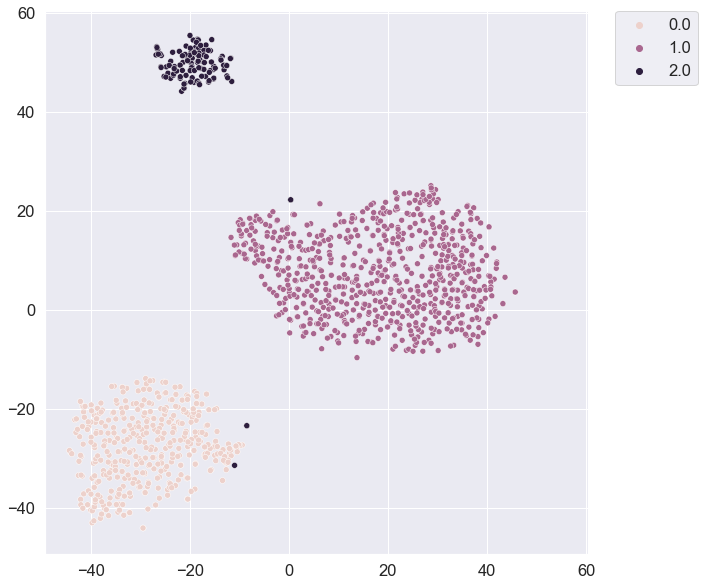

In [27]:
fig, ax = plt.subplots(1,figsize=(10,10))
sns.scatterplot(x=latent_embedded[:,0],y=latent_embedded[:,1],hue=labels,ax=ax)
lim = (latent_embedded.min()-5, latent_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
fig.savefig('tsne.svg',bbox_inches='tight')

# Generate Latents

In [6]:
images = []
image_tensors = []
t2_file_list = os.listdir('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_BROWN/input_raw/')
t2_file_list = [os.path.join('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_BROWN/input_raw/',x) for x in t2_file_list]
for t2_file in tqdm(t2_file_list,total=len(t2_file_list)):
    images.append(sitk.ReadImage(t2_file))
    subject = tio.Subject(t2=tio.ScalarImage(t2_file))
    transform_1 = tio.Compose([
        tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.ToCanonical(),
        tio.transforms.Resample((1.,1.,1.)),
    ])
    subject = transform_1(subject)
    edge_max = max(subject.t2.data.shape)
    padding = ((edge_max - subject.t2.data.shape[1]) // 2, 
                (edge_max - subject.t2.data.shape[2]) // 2,
                    (edge_max - subject.t2.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)
    image_tensor = subject.t2.data.unsqueeze(0).float()
    image_tensors.append(image_tensor)

  0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
latent_dhcp = []
for img,gt in tqdm(dhcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'latent_dhcp.pt')
latent_hcp = []
for img,gt in tqdm(hcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'latent_hcp.pt')
latent_brown = []
for img in tqdm(image_tensors):
    img = img.cuda()
    with torch.no_grad():
        latent_brown.append(kl_forward_latent(model,img))
latent_brown = torch.cat(latent_brown,dim=0)
torch.save(latent_brown,'latent_brown.pt')

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/712 [00:00<?, ?it/s]